#**Modelo de Regressão Linear Múltipla**
Sua tarefa é **prever os valores médios** das casas nos distritos da Califórnia 🏡, considerando uma série de características desses distritos.

Vamos lá? 😀

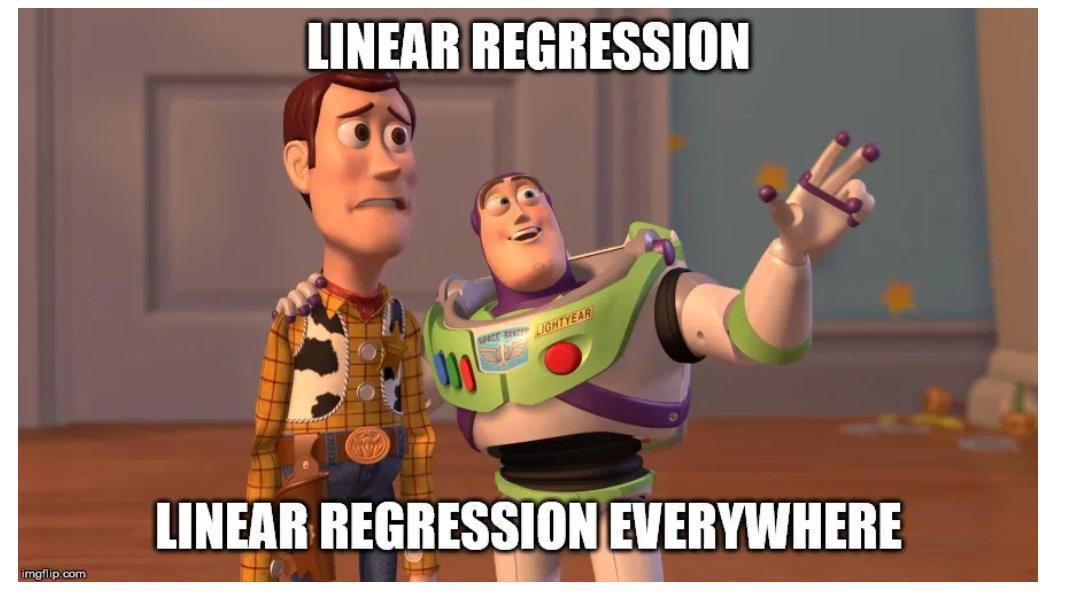

# Importando os dados

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv("insurance.csv")

In [3]:
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Configurações

Primeiro, vamos garantir que este notebook funcione bem em python 2 e 3, importar alguns módulos comuns, garantir que o MatplotLib plote figuras em linha.

In [4]:
# para deixar todas as saídas com os mesmos valores obtidos na live.
import numpy as np
np.random.seed(42) # Instancia uma semente aleatória, que é útil quando você deseja garantir que os números aleatórios gerados sejam os mesmos em diferentes execuções do código, o que é crucial para reproduzibilidade em experimentos ou análises em um time.
import os

# Para plots bonitinhos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Conhecendo os dados 🤓

In [5]:
dataset.shape

(1338, 7)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Não temos linhas com valores nulos nas respectivas colunas. Vamos analisar se existe alguma linha duplicada.

In [7]:
dataset.duplicated().sum()

1

In [8]:
duplicados = dataset[dataset.duplicated()]

# Exibir os registros duplicados
print(duplicados)

     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


### Vamos excluir a(s) linha(s) duplicadas

In [ ]:
#dataset = dataset.drop_duplicates()
#dataset.duplicated().sum()

Agora vamos analisar os dados do tipo numérico com a função describe():

In [9]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


Analisando algumas distribuições com histogramas:

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

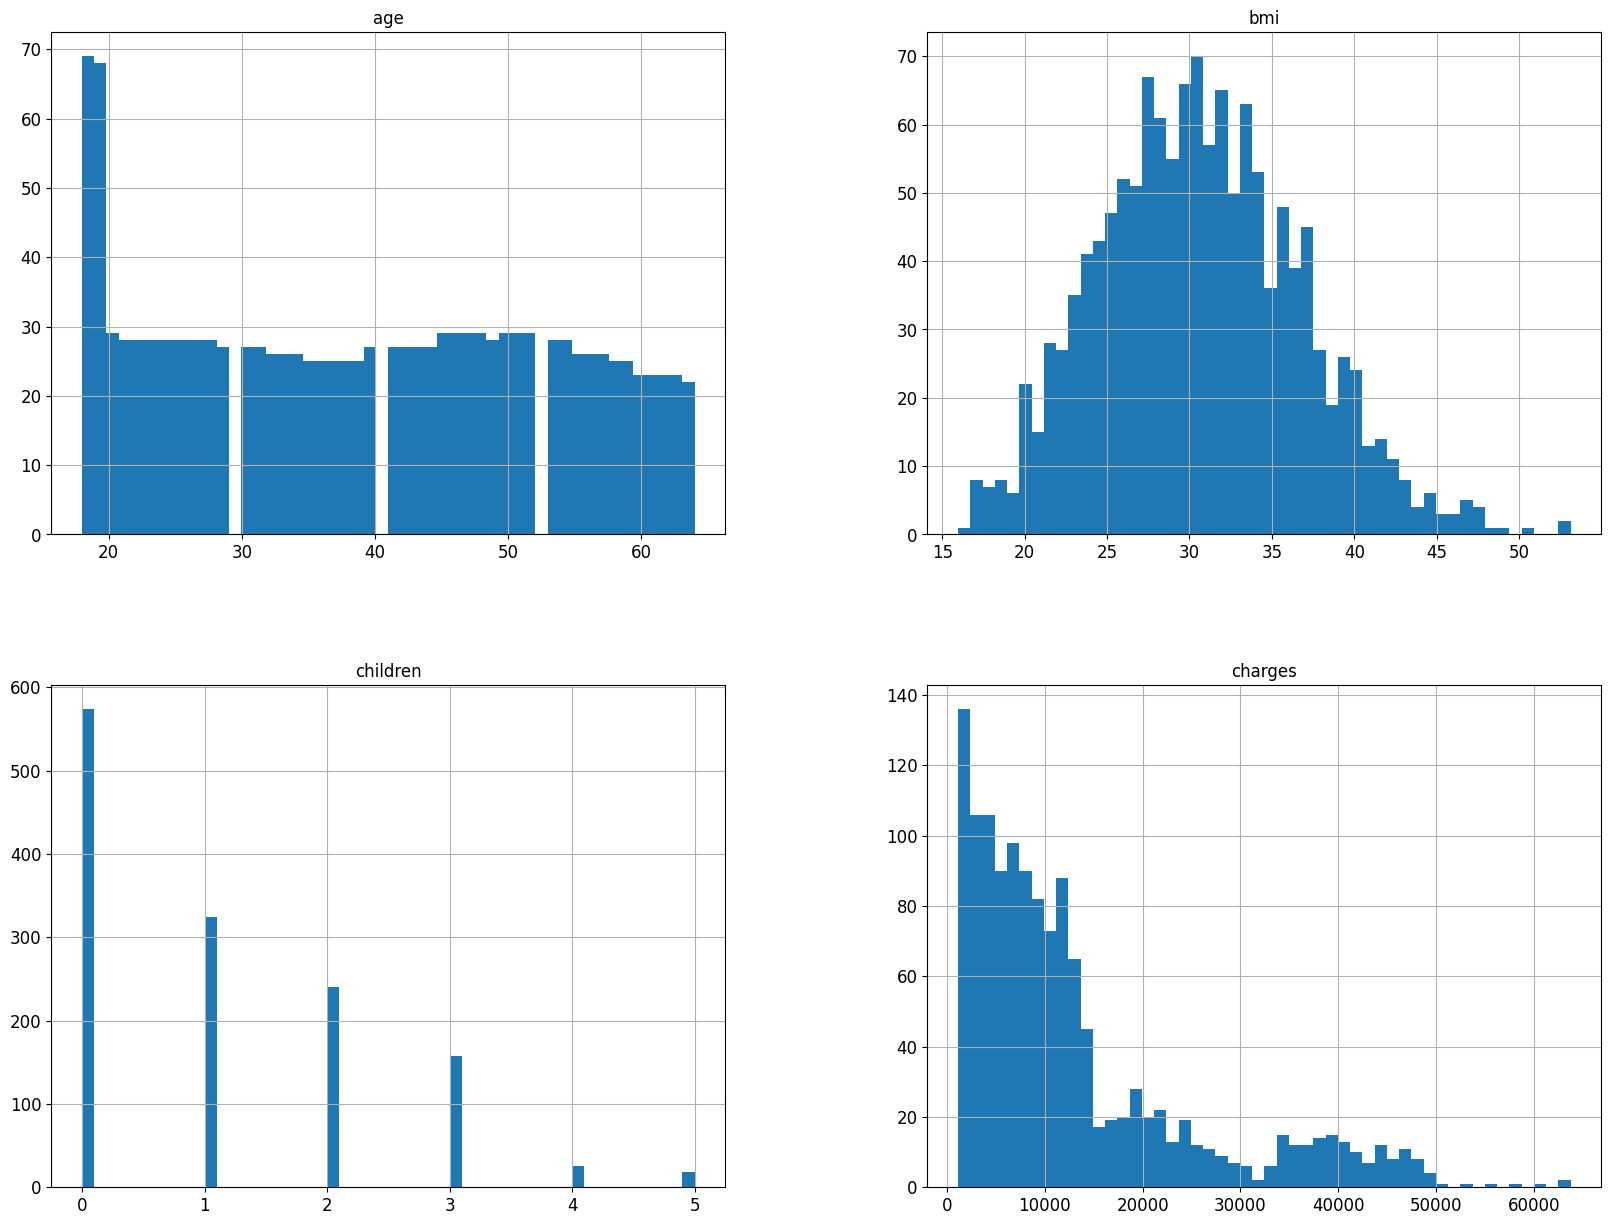

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(20,15))

# Separando as bases em treino e teste

In [11]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(dataset, test_size = 0.2, random_state = 7)

In [12]:
print(len(df_train), "treinamento +", len(df_test), "teste")

1070 treinamento + 268 teste


## Criando categorias de IMC (Índice de massa corporal) 🤑

<Axes: >

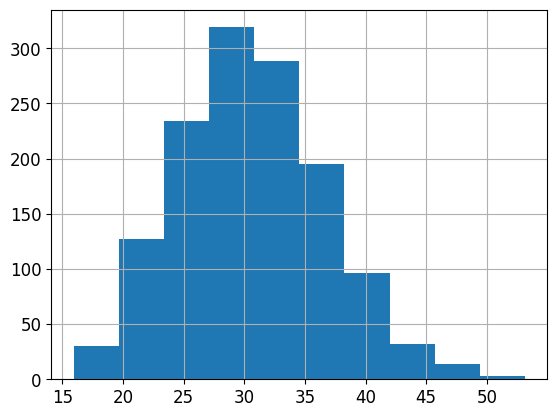

In [13]:
dataset["bmi"].hist()

In [14]:
#cut do Pandas, que é comumente usada para dividir um conjunto de dados em intervalos discretos chamados de "bins" (intervalos ou faixas)
dataset["bmi_cat"] = pd.cut(dataset["bmi"],
                               bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

dataset["bmi_cat"].value_counts()

bmi_cat
4    397
3    380
5    226
2    221
6     93
1     21
Name: count, dtype: int64

<Axes: >

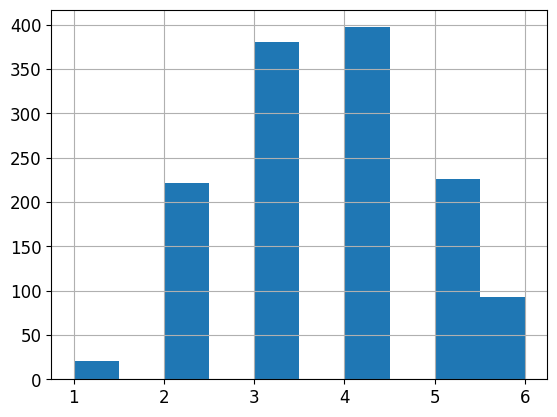

In [15]:
dataset["bmi_cat"].hist()

Resumindo, esse código está transformando valores contínuos de índice de massa corporal em categorias discretas, dividindo-os em intervalos específicos, garantindo que o número de categorias seja limitado e, finalmente, atribuindo rótulos numéricos a essas categorias.

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

dataset['sex_type'] = label_encoder.fit_transform(dataset['sex'])
dataset['smoker_type'] = label_encoder.fit_transform(dataset['smoker'])
dataset['region_type'] = label_encoder.fit_transform(dataset['region'])

dataset.head()

,age,sex,bmi,children,smoker,region,charges,bmi_cat,sex_type,smoker_type,region_type
0,19,female,27.900,0,yes,southwest,16884.92400,3,0,1,3
1,18,male,33.770,1,no,southeast,1725.55230,4,1,0,2
2,28,male,33.000,3,no,southeast,4449.46200,4,1,0,2
3,33,male,22.705,0,no,northwest,21984.47061,2,1,0,1
4,32,male,28.880,0,no,northwest,3866.85520,3,1,0,1


In [17]:
dataset_tratado = dataset.drop(columns = [ "bmi", "smoker", "region", "sex"]).copy()

dataset_tratado.head()

,age,children,charges,bmi_cat,sex_type,smoker_type,region_type
0,19,0,16884.92400,3,0,1,3
1,18,1,1725.55230,4,1,0,2
2,28,3,4449.46200,4,1,0,2
3,33,0,21984.47061,2,1,0,1
4,32,0,3866.85520,3,1,0,1


Boa! Agora com as categorias criadas, vamos realizar a amostragem estratificada com base no índice de massa corporal.

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)
for train_index, test_index in split.split(dataset_tratado, dataset_tratado["bmi_cat"]):
    strat_train_set = dataset_tratado.loc[train_index]
    strat_test_set = dataset_tratado.loc[test_index]

In [19]:
# Analisando as proporções de teste
strat_test_set["bmi_cat"].value_counts() / len(strat_test_set)

bmi_cat
4    0.298507
3    0.283582
5    0.167910
2    0.164179
6    0.070896
1    0.014925
Name: count, dtype: float64

In [20]:
# Analisando as proporções de treino
strat_train_set["bmi_cat"].value_counts() / len(strat_train_set)

bmi_cat
4    0.296262
3    0.284112
5    0.169159
2    0.165421
6    0.069159
1    0.015888
Name: count, dtype: float64

In [21]:
dataset["bmi_cat"].value_counts() / len(dataset)# Fazer o mesmo para o dataset original

bmi_cat
4    0.296712
3    0.284006
5    0.168909
2    0.165172
6    0.069507
1    0.015695
Name: count, dtype: float64

In [22]:
# Removendo o income_cat das bases de treino e teste
# O uso do termo set_ é uma convenção para indicar que é uma variável temporária que itera sobre um conjunto de dados (um conjunto de treinamento ou um conjunto de teste).

for set_ in (strat_train_set, strat_test_set):
   set_.drop("bmi_cat", axis=1, inplace=True)

In [23]:
insurance = strat_train_set.copy()

# Buscando correlações 🔎

In [24]:
corr_matrix = insurance.corr(numeric_only=True)

In [25]:
corr_matrix["charges"].sort_values(ascending=False)

charges        1.000000
smoker_type    0.792554
age            0.291266
children       0.063776
sex_type       0.060243
region_type   -0.000168
Name: charges, dtype: float64

**Nos dados anteriores a smoker_type apresenta a correlação mais alta**

In [26]:
insurance.head()

,age,children,charges,sex_type,smoker_type,region_type
458,56,0,10601.41200,1,0,3
558,35,3,39983.42595,0,1,1
172,18,0,1694.79640,1,0,0
30,22,0,35585.57600,1,1,3
475,61,1,28868.66390,1,1,1


array([[<Axes: xlabel='charges', ylabel='charges'>,
        <Axes: xlabel='smoker_type', ylabel='charges'>,
        <Axes: xlabel='age', ylabel='charges'>],
       [<Axes: xlabel='charges', ylabel='smoker_type'>,
        <Axes: xlabel='smoker_type', ylabel='smoker_type'>,
        <Axes: xlabel='age', ylabel='smoker_type'>],
       [<Axes: xlabel='charges', ylabel='age'>,
        <Axes: xlabel='smoker_type', ylabel='age'>,
        <Axes: xlabel='age', ylabel='age'>]], dtype=object)

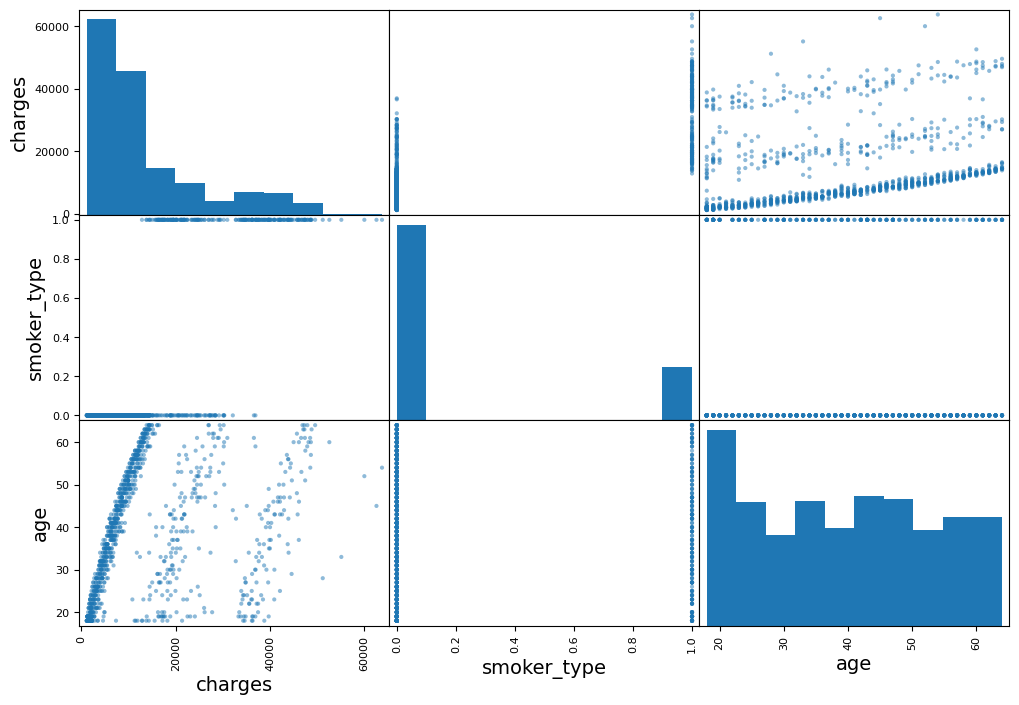

In [28]:
# from pandas.tools.plotting import scatter_matrix
from pandas.plotting import scatter_matrix

attributes = ["charges", "smoker_type", "age"]
scatter_matrix(insurance[attributes], figsize=(12, 8))

Analisando as correlações, a feature que se apresenta mais promissora para prever o custo do plano de saúde parece ser a **age**.

smoker_type : 0.299008 de correlação.

Vamos plotar essas duas features em um gráfico de scatter para analisar com mais detalhes:

(18.0, 65.0, 1100.0, 68000.0)

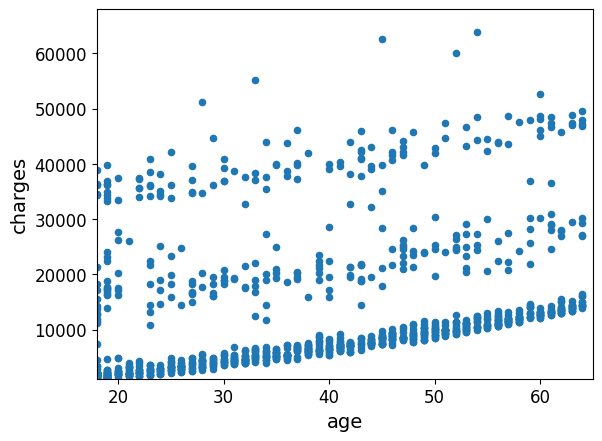

In [29]:
insurance.plot(kind="scatter", x="age", y="charges", alpha=1)
plt.axis([18, 65, 1100, 68000])

# Preparando os dados para colocar no algoritmo 🧰

In [30]:
strat_train_set.head()

,age,children,charges,sex_type,smoker_type,region_type
458,56,0,10601.41200,1,0,3
558,35,3,39983.42595,0,1,1
172,18,0,1694.79640,1,0,0
30,22,0,35585.57600,1,1,3
475,61,1,28868.66390,1,1,1


# Preparando os dados para colocar no algoritmo 🧰

In [32]:
strat_train_tratado_set = strat_train_set.drop(columns = [ "sex_type", "smoker_type", "region_type"]).copy()

dataset_tratado = strat_train_tratado_set.drop("charges", axis=1) # apagando a target para a base de treino (nosso x)
dataset_tratado_labels = strat_train_tratado_set["charges"].copy() #armazenando a target (nosso y)

In [33]:
dataset_tratado.head()

,age,children
458,56,0
558,35,3
172,18,0
30,22,0
475,61,1


# Criando a pipeline de pré-processamento dos dados 🔧

Agora vamos construir um pipeline para pré-processar os atributos numéricos:

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        #('imputer', SimpleImputer(strategy="median")), #substituindo valores nulos pela mediana
        ('std_scaler', StandardScaler()), # padronizando as escalas dos dados
    ])

dataset_tratado_padronizado = num_pipeline.fit_transform(dataset_tratado)

In [35]:
dataset_tratado_padronizado

array([[ 1.1966697 , -0.91977598],
       [-0.30283778,  1.5633871 ],
       [-1.51672478, -0.91977598],
       ...,
       [ 0.48261852, -0.09205496],
       [ 0.12559293,  0.73566607],
       [ 0.62542875, -0.91977598]])

In [36]:
type(dataset_tratado_padronizado)

numpy.ndarray

In [37]:
column_names = ['age', 'children']

# Transformar o array em DataFrame
insurance_df = pd.DataFrame(data=dataset_tratado_padronizado, columns=column_names)

# Exibir o DataFrame resultante
print(insurance_df.shape)

(1070, 2)


In [38]:
insurance_df.head()

,age,children
0,1.196670,-0.919776
1,-0.302838,1.563387
2,-1.516725,-0.919776
3,-1.231104,-0.919776
4,1.553695,-0.092055


Prontinho! Nossos dados estão limpinhos e organizados 🌟

# Escolhendo o melhor modelo de regressão 📈

Vamos começar com a velha e boa regressão linear!

- Equação do 1° grau.

- A Regressão Linear busca entender o padrão de um valor dependendo de outro ou outros, e assim encontrar uma função que expressa esse padrão.

- **Foco**: buscar o melhor valor que os coeficientes possam atingir, de maneira que a diferença entre o valor predito pela função e o real, sejam os menores.





In [39]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(dataset_tratado, dataset_tratado_labels)

LinearRegression()

In [ ]:
# vamos tentar o pipeline de pré-processamento completo em algumas instâncias de treinamento
some_data = dataset_tratado.iloc[:5]
some_labels = dataset_tratado_labels.iloc[:5]

predictions = lin_reg.predict(some_data)

print("Predictions:", lin_reg.predict(some_data))

Compare com os valores reais:

In [ ]:
print("Labels:", list(some_labels))

# Avaliando o modelo ✅

O **MSE** mede a média dos quadrados das diferenças entre os valores previstos pelo modelo e os valores reais observados no conjunto de dados.

Quanto menor o valor do MSE, melhor o ajuste do modelo aos dados.

In [ ]:
from sklearn.metrics import mean_squared_error
# erro médio quadrático eleva ao quadrado a média do erro médio absoluto. Estou avaliando se os erros não são tão grandes, esses erros são penalizados.
# penaliza muito mais valores distantes da média.

insurance_predictions = lin_reg.predict(dataset_tratado)
lin_mse = mean_squared_error(dataset_tratado_labels, insurance_predictions)
lin_rmse = np.sqrt(lin_mse) # raiz quadrada aqui
lin_rmse

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(dataset_tratado_labels, insurance_predictions)
lin_mae

Um erro de margem de 69050 dólares não é muito aceitável no nosso modelo sendo que os valores de median_housing_values variam entre  120 mil dólares e 265 mil dólares 😞 Podemos definir aqui que esse modelo está com overfiting.
Vamos tentar um modelo mais poderoso?

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2 = r2_score(dataset_tratado_labels, insurance_predictions)
print('r²',r2)

In [ ]:
# Função para calcular o MAPE (Mean Absolute Percentage Error)

def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape

In [ ]:
# Calcular o MAPE
mape_result = calculate_mape(dataset_tratado_labels, insurance_predictions)

# Imprimir o resultado
print(f"O MAPE é: {mape_result:.2f}%")

# Que tal tentar outros models? 🌲

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Criando o modelo de DecisionTreeRegressor
model_dtr = DecisionTreeRegressor(max_depth=10)
model_dtr.fit(dataset_tratado, dataset_tratado_labels)

In [ ]:
# vamos tentar o pipeline de pré-processamento completo em algumas instâncias de treinamento
some_data = dataset_tratado.iloc[:5]
some_labels = dataset_tratado_labels.iloc[:5]

predictions = model_dtr.predict(some_data)

print("Predictions:", predictions)

In [ ]:
print("Labels:", list(some_labels))

In [ ]:
# mean_squared_error
housing_predictions = model_dtr.predict(dataset_tratado)
lin_mse = mean_squared_error(dataset_tratado_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(f'Erro Médio Quadrático (RMSE): {lin_rmse}')

In [ ]:
# mean_absolute_error
lin_mae = mean_absolute_error(dataset_tratado_labels, housing_predictions)
print(f'Erro Absoluto Médio (MAE): {lin_mae}')

In [ ]:
r2 = r2_score(dataset_tratado_labels, housing_predictions)
#print('r²',r2)
print(f'R² (coeficiente de determinação) (R-squared)(r²): {r2}')

In [ ]:
# Calcular o MAPE (Mean Absolute Percentage Error)
mape_result = calculate_mape(dataset_tratado_labels, housing_predictions)

# Imprimir o resultado
print(f"O MAPE é: {mape_result:.2f}%")